### Imports

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
plt.rcParams.update({'font.size': 17})

### Dataloading Methods

In [108]:
def get_target_predictions(results_file):
    predictions = []
    with open(results_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Target prediction' in line and not 'retraining' in line:
                prediction = line[line.find('[[')+2:line.find(']]')]
                prediction_vals = prediction.split(', ')
                predictions.append(float(prediction_vals[0]))
    return predictions[:10]

def get_network_results(path):
    results = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            epoch = int(line[0].split(': ')[1])
            loss = float(line[1].split(': ')[1])
            fake_correct = int(line[2].split(': ')[1])
            fake_incorrect = int(line[3].split(': ')[1])
            real_correct = int(line[4].split(': ')[1])
            real_incorrect = int(line[5].split(': ')[1])
            results.append((epoch, loss, fake_correct, fake_incorrect, real_correct, real_incorrect))
    return results

def get_output_results(file):
    results = []
    with open(file, 'r') as f:
        while line := f.readline():
            if 'Finished evaluation' in line:
                real_correct, real_incorrect, fake_correct, fake_incorrect, loss = line[line.find(':')+2:].split()
                real_correct, real_incorrect, fake_correct, fake_incorrect = int(real_correct), int(real_incorrect), int(fake_correct), int(fake_incorrect)
                loss = float(loss)
                results.append((loss, fake_correct, fake_incorrect, real_correct, real_incorrect))
    return results

def get_accuracies(results_file):
    accuracies = []
    results = get_output_results(results_file)
    for result in results:
        fake_correct = result[1]
        fake_incorrect = result[2]
        real_correct = result[3]
        real_incorrect = result[4]
        accuracy = (fake_correct + real_correct)/(fake_correct + fake_incorrect + real_correct + real_incorrect)
        accuracies.append(accuracy)
    return accuracies

def get_poison_target_feature_dist(file):
    dists = []
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Poison-target' in line:
                dist = float(line[line.find(':')+2:])
                dists.append(dist)
            if 'created' in line:
                return dists
            if 'too far' in line:
                dists = []
    return dists

def get_poison_base_dist(file):
    dists = []
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Poison-base' in line:
                dist = float(line[line.find(':')+2:])
                dists.append(dist)
            if 'created' in line:
                return dists
            if 'too far' in line:
                dists = []
    return dists

def get_orginal_target_pred(file):
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Original target prediction' in line:
                start = line.find('[[')+2
                end = line[line.find('[[')+2:].find(',')
                return float(line[start:start+end])
    return -10000

def get_final_target_pred(file):
    last_pred = -100000
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if 'Target prediction after retraining from scratch' in line:
                start = line.find('[[')+2
                end = line[line.find('[[')+2:].find(',')
                return float(line[start:start+end])
            elif "Target prediction" in line:
                start = line.find('[[')+2
                end = line[line.find('[[')+2:].find(',')
                last_pred = float(line[start:start+end])
    return last_pred

### Graphing methods

In [136]:
def graph_target_class(file, log=False):
    predictions = get_target_predictions(file)
    epochs = range(1, len(predictions)+1)
    plt.plot(epochs, predictions)
    if log:
        plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Probability of real class')
    plt.title('Target classification per epoch')
    plt.legend()
    plt.show()
    
def graph_target_class_multiple(files, log=False, title=None, const=None):
    for file in files:
        predictions = get_target_predictions(file)
        epochs = range(1, len(predictions)+1)
        plt.plot(epochs, predictions)
    if log:
        plt.yscale('log')
    if const:
        plt.axhline(y = const, color='red', linestyle = 'dashed') 
    plt.xlabel('Epoch')
    plt.ylabel('Probability of real class')
    plt.xticks(epochs)
    if title:
        plt.title(title)
    else:
        plt.title('Target classification per epoch')
    plt.show()

def graph_accuracy(file, log=False):
    accuracies = get_accuracies(file)
    epochs = range(1, len(accuracies)+1)
    plt.plot(epochs, accuracies)
    if log:
        plt.yscale('log')
    plt.xticks(epochs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Network accuracy per epoch')
    plt.legend()
    plt.show()
    
def graph_poison_distances(files, iterations):
    target_dists = [get_poison_target_feature_dist(file) for file in files]
    base_dists = [get_poison_base_dist(file) for file in files]
    minimum = sorted([len(get_poison_target_feature_dist(file)) for file in files]
                            + [len(get_poison_base_dist(file)) for file in files])[0]
    x = range(0, iterations, 100)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i in range(len(files)):
        ax1.plot(x, target_dists[i][:minimum], 'g-', label='Target')
        ax2.plot(x, base_dists[i][:minimum], 'b-', label='Base')
    
    ax1.set_yscale('log')
    
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Target distance', color='g')
    ax2.set_ylabel('Base distance', color='b')
    plt.title('Poison distances')
    plt.show()

def graph_target_class_accuracy(file, original_pred=False):
    accuracies = get_accuracies(file)
    predictions = get_target_predictions(file)
    print(accuracies, predictions)
    epochs = range(1, len(accuracies)+1)
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.plot(epochs, predictions, label='Prediction')
    if original_pred:
        or_pred = get_orginal_target_pred(file)
        plt.axhline(y = or_pred, color='red', linestyle = 'dashed') 
    plt.xticks(epochs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy/Prediction')
    plt.title(f'Network accuracy and target prediction')
    plt.legend()
    plt.show()

### Data paths

In [134]:
meso_face_outputs = [
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41630327',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41630330',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634167',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634168',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634169',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634170',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634899',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634900']

xception_full_base_20_outputs = [
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876787',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876788',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876789',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876791',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876793',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876794',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876795',
    'results_for_diss/attack_xception_full_baseline/20_poisons/attack_xception_full_baseline.o39876796']

xception_full_base_50_outputs = [
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40111805',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40111942',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40124036',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40143603',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40143604',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40143605',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40143606',
    'results_for_diss/attack_xception_full_baseline/50_poisons/attack_xception_full_baseline_50.o40143607']

xception_full_base_v2_outputs = [
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41020483',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41020484',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41020485',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41020487',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41051567',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41051568',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41051569',
    'results_for_diss/attack_xception_full_baseline_v2/attack_xception_full_baseline_v2.o41051567']

xception_face_base_v2_outputs = [
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41258435',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41258443',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41258445',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41258447',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41401530',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41401532',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41401534',
    'results_for_diss/attack_xception_face_baseline_v2/attack_xception_face_baseline_v2.o41401536']

meso_face_base_v2_outputs = [
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41630327',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41630330',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634167',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634168',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634169',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634170',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634899',
    'results_for_diss/attack_meso_face_baseline_v2/attack_meso_face_baseline_v2.o41634900']

full_finetune = [
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41851576',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41863660',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41863661',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41863677',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41863678',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41895996',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41895997',
    'results_for_diss/finetuning_full/attack_xception_full_finetune.o41895998'
]

face_finetune = [
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41790764',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41790769',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41824482',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41824483',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41836648',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41879477',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41879478',
    'results_for_diss/finetuning_face/attack_xception_face_finetune.o41879479']

### Graphs

#### Baseline 20 poisons

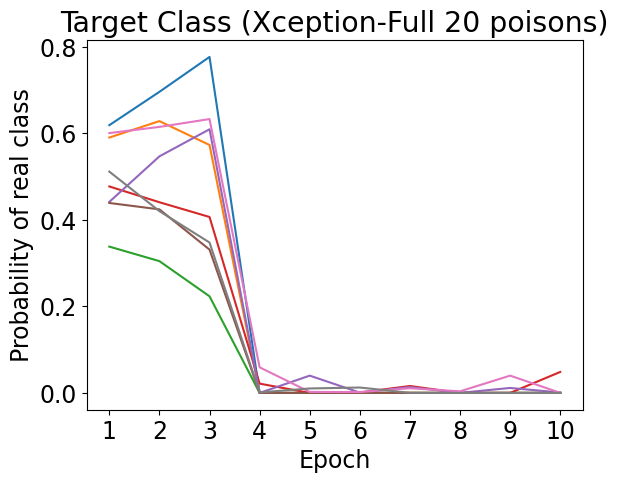

In [32]:
graph_target_class_multiple(xception_full_base_20_outputs, title="Target Class (Xception-Full 20 poisons)")

#### Baseline 50 poisons

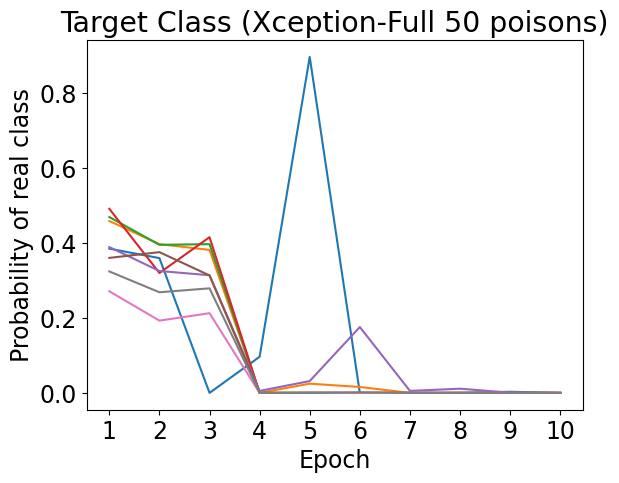

In [33]:
graph_target_class_multiple(xception_full_base_50_outputs, title="Target Class (Xception-Full 50 poisons)")

#### Baseline v2 Xception-Full

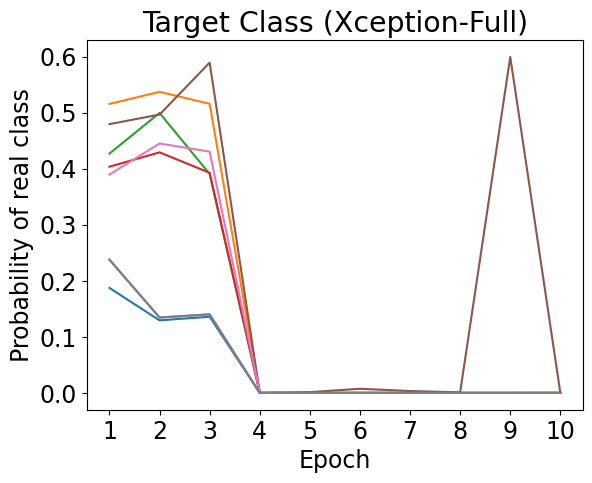

In [34]:
graph_target_class_multiple(xception_full_base_v2_outputs, title="Target Class (Xception-Full)")

#### Baseline v2 Xception-Face

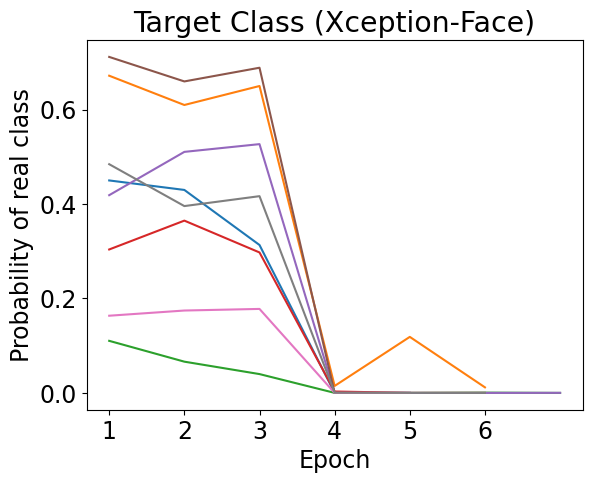

In [36]:
graph_target_class_multiple(xception_face_base_v2_outputs, title="Target Class (Xception-Face)")

#### Baseline v2 Meso-Face

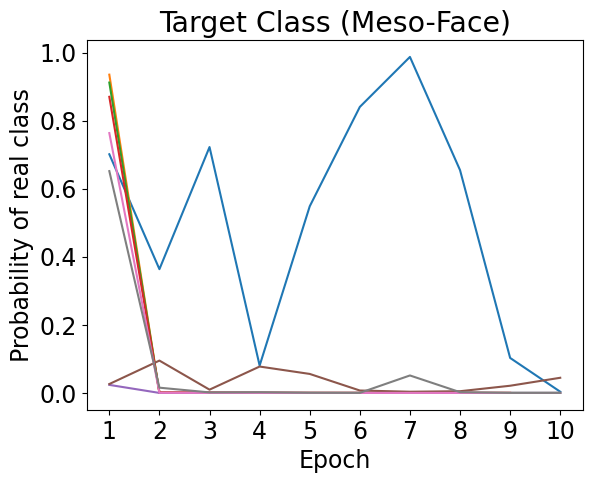

In [38]:
graph_target_class_multiple(meso_face_base_v2_outputs, title="Target Class (Meso-Face)")

#### Finetune Full

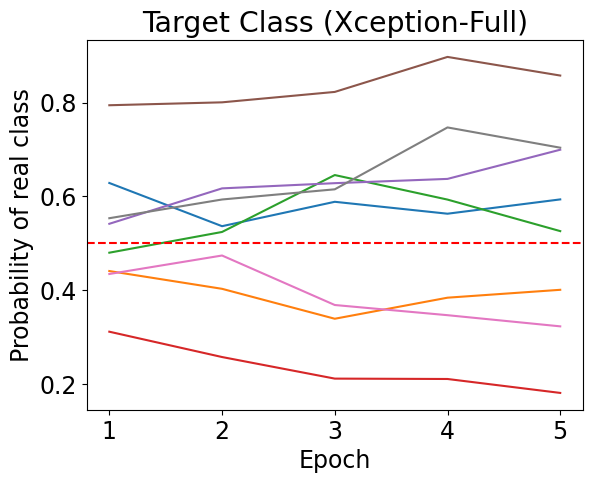

In [138]:
graph_target_class_multiple(full_finetune, title="Target Class (Xception-Full)", const=0.5)

#### Finetune Face

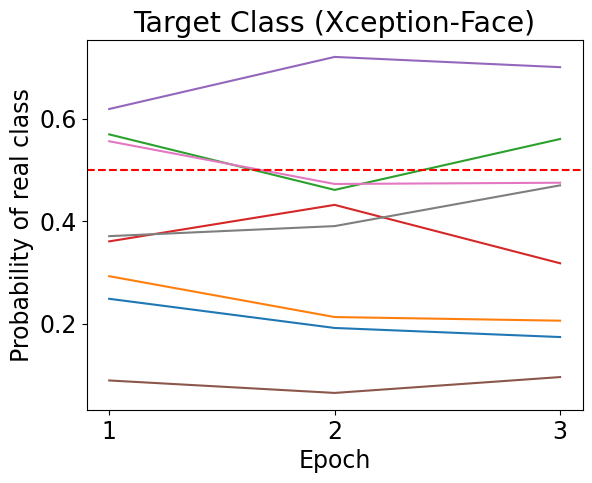

In [137]:
graph_target_class_multiple(face_finetune, title="Target Class (Xception-Face)", const=0.5)

[0.6997603560424512, 0.7152864949852283, 0.7267805292454386] [0.2484, 0.1915, 0.1738]


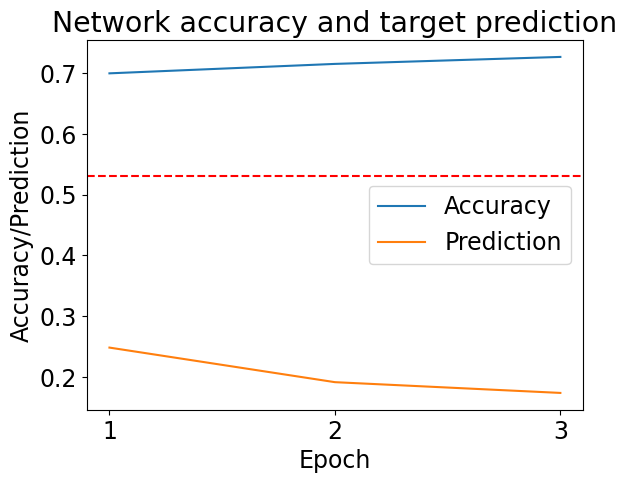

In [125]:
graph_target_class_accuracy(face_finetune[0], original_pred=True)

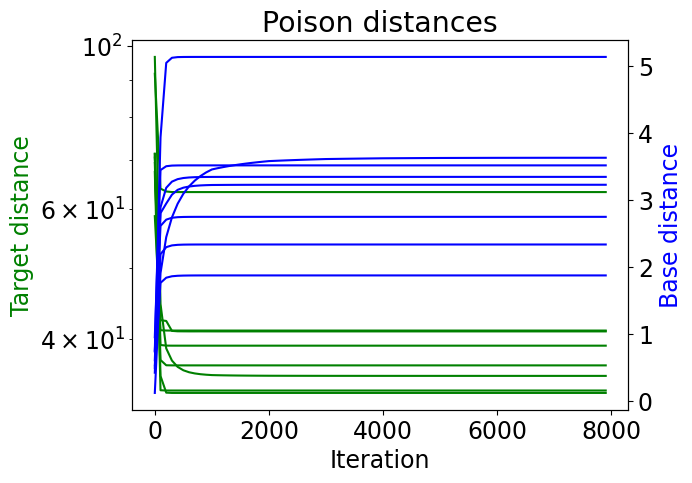

In [6]:
graph_poison_distances(meso_face_outputs,8000)

### Numeric Results

#### Meso Base 2

In [88]:
results_before = [get_orginal_target_pred(file) for file in meso_face_base_v2_outputs]
results_after = [get_final_target_pred(file) for file in meso_face_base_v2_outputs]
before = np.average(results_before)
after = np.average(results_after)
std = np.std(results_after)
rel = after/before
ab = after - before
before, after, std, rel, ab

(0.0049660469509625,
 0.006030036231527125,
 0.014584460044835075,
 1.214252763026819,
 0.001063989280564625)

#### Xception-Face Base 2

In [89]:
results_before = [get_orginal_target_pred(file) for file in xception_face_base_v2_outputs]
results_after = [get_final_target_pred(file) for file in xception_face_base_v2_outputs]
before = np.average(results_before)
after = np.average(results_after)
std = np.std(results_after)
rel = after/before
ab = after - before
before, after, std, rel, ab

(0.00046284916527438737,
 0.00149789972165725,
 0.00389424691419086,
 3.236258880945073,
 0.0010350505563828626)

#### Xception-Full Base 2

In [93]:
results_before = [get_orginal_target_pred(file) for file in xception_full_base_v2_outputs]
results_after = [get_final_target_pred(file) for file in xception_full_base_v2_outputs]
before = np.average(results_before)
after = np.average(results_after)
std = np.std(results_after)
rel = after/before
ab = after - before
before, after, std, rel, ab

(0.004612633102575891,
 2.4929214024999998e-05,
 3.508396214161932e-05,
 0.0054045516889428,
 -0.004587703888550891)

#### Xception-Full Base 20

In [94]:
results_before = [get_orginal_target_pred(file) for file in xception_full_base_20_outputs]
results_after = [get_final_target_pred(file) for file in xception_full_base_20_outputs]
before = np.average(results_before)
after = np.average(results_after)
std = np.std(results_after)
rel = after/before
ab = after - before
before, after, std, rel, ab

(0.0005262408678931326,
 0.006219513991375,
 0.01598329477008222,
 11.818758995810338,
 0.0056932731234818675)

#### Xception-Full Base 50

In [95]:
results_before = [get_orginal_target_pred(file) for file in xception_full_base_50_outputs]
results_after = [get_final_target_pred(file) for file in xception_full_base_50_outputs]
before = np.average(results_before)
after = np.average(results_after)
std = np.std(results_after)
rel = after/before
ab = after - before
before, after, std, rel, ab

(0.00019400753816973713,
 0.00043238586570124997,
 0.0010102214387702271,
 2.228706522336033,
 0.00023837832753151284)